# <span style="color: blue;">Analysing method related differences script - bioinformatic differences</span>

This script goes through the investigating discrepancies between the 4 methods

1. ABRicate (our baseline method)
2. ARIBA
3. KmerResistance
4. SRST2

**NOTE FOR EASE OF READING, SOME CODE IS REPEATED IN EACH SECTION, TO MAKE EACH SECTION BE A DISCREET UNIT OF ANALYSIS, THIS LENGTHANS THE RUNTIME OF THE CODE BUT MAKES IT EASIER TO UNDERSTAND. THE RUNTIME IS STILL SHORT (< 2 hours even comparing all database similarities)**

### <span style="color: green;">Highlighting database dependency.</span>

For each of several databases, it does the following:
1. reads in all the results we obtained
3. This is then used to produce **Figure X** 


Databases used
**Primary**
Resfinder 1st October 2019 release 
**Secondary**
* CARD 23rd October 2019 release
* beta-lactam.fsa of the Resfinder 1st October 2019 release
* aminoglycoside.fsa  of the Resfinder 1st October 2019 release
* quinolone.fsa of the Resfinder 1st October 2019 release
* trimethoprim.fsa of the Resfinder 1st October 2019 release
* sulphonamide.fsa of the Resfinder 1st October 2019 release
* Resfinder 22nd of January 2019 release
* Resfinder 22nd of January 2018 release
* Resfinder 26th of January 2017 release



From here on, we are investigating causes of error and only use the Resfinder 1st October 2019 release.

### <span style="color: green;">Identifying which TRGs are most commonly discrepant and then </span>

1. For this we first identify which reported TRGs likely represent the same gene found differently by the different programs (see image below)

![image](method_1.png)

2. We then look at patterns of discrepancy and identify the 10 most common across the data
3. We then demonstrate what we believe the cause of each of these is (simulated example in each cell of the notebook)





### <span style="color: green;">Highlighting extent of annotation errors</span>

This then goes through how we determine if an error is likely due to annotation or not

1. For each discrepant, we identify if any of the identified TRGs are complete within the assembly.
2. If so, we take the containing contig and simulate **perfect* reads at 50x and 500x from it (10 times each).
3. We then observe if the same misclassification pattern occurs again. If so the error is deemed likely annotation
4. This is then used to produce **Figure XX** in the paper.

Note for some of the code from this section is only presented here in markdown as I can't provide any full sequence files on GitHub. However, the sequences for this project are available on NCBI and the code can be recreated to analyse these scripts here.

### <span style="color: green;">Investigating non annotation errors.</span>

This section finally ends on investigation of 6 samples where different beta-lcatamase genes were reported but were not artefactual.





## <span style="color: blue;">Setup</span>

**So first steps are to load in required modules and then identify all the output reports**


#### Dependencies

1. Python 3 
2. Biopython
3. Pandas
4. Numpy
5. tqdm
6. networkx

#### Inputs
Some notes for this step, firstly which files we take
1. for ABRicate we take each contigs.tab file
2. for ARIBA we use its summary file
3. for KmerResistance we use the .KmerRes files
4. for SRST2 we use the .out__fullgenes__seqs_clustered__results.txt files

Note these were chosen as they seem to follow guidelines and where no guidelines available, give us the most closely matching results between the four programs

Note also SRST2 does not produce output if it finds no genes. The others all do

#### Resfinder database

For this we load
1. The naming link database
2. For each of the sub databases by antibiotic class 
  * beta-lactam
  * quinolone
  * aminoglycoside
  * sulfa antibiotics
  * trimethoprim
3. The whole database

We do 1 so the results are interpretable
We do 2 so we can breakdown results by antibiotic class as well as specific genes
We do 3 to do all versus all of the resistance database


In [25]:
# =============================================================================
# Code block 1 - Requirements
# =============================================================================


# We start by importing required modules
# File structure
import os
import csv
from collections import Counter

# Pandas
import pandas as pd
import numpy as np
import networkx as nx
# These are the fundamental modules used for analysing the data


# Pictures
import matplotlib.pyplot as plt
import seaborn as sns

# Sequence manipulation
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
# These modules are priarily used for loading the database, and then for identifying whether there are any
# Perfrect protein matches in the dataset


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other general
from tqdm import tnrange, tqdm_notebook
# We just import this to check our code runs sensibly and to get timing estimates for stuff
from copy import deepcopy

#Looking at local files
%ls 



by_trg_pattern.csv
gene_naming.csv
interpreting_simulations.csv
isolate_patterns.csv
legacy_code/
main_analysis.ipynb
meta_data.csv
method_1.png
method_1.svg
method_combinations.png
method_image.png
notes_random.txt
pattern_annotator.csv
readymade_card_20191023_full_sim_matrix.csv
readymade_resfinder_20170126_full_sim_matrix.csv
readymade_resfinder_20180122_full_sim_matrix.csv
readymade_resfinder_20190122_full_sim_matrix.csv
readymade_resfinder_20191001_ami_sim_matrix.csv
readymade_resfinder_20191001_blm_sim_matrix.csv
readymade_resfinder_20191001_full_sim_matrix.csv
readymade_resfinder_20191001_qui_sim_matrix.csv
readymade_resfinder_20191001_sul_sim_matrix.csv
readymade_resfinder_20191001_tri_sim_matrix.csv
result_tarballs/
simulation_analysis.ipynb
simulation_contigs.csv


## <span style="color: blue;">Loading results</span>

### Loading the output files - Code block 2

The following block of code finds all the result files and puts them together into a single dictionary
Note we re-ran each program several times using several different databases. Most of these results aren't in the main text (aside from those pertaining to the 20191001 database) but refer to tings in the supplementary.
Also note we re-ran each database on the sub-databases of interest to make sure different sub-databases didn't interfere with one another.

### Results all contained within the result_tarballs directory and dbs all contained within the ../db_preparation directory 

Following dictionary links tarballs (for results), and database files, so that all can be analysed together
All tarballs available in result_tarballs. please run tar -xzvf * on all tarballs prior to running this code
Note we don't provide all the results as the files become large and difficult to work with in this small repo
Instead we just keep the files we need. These can all be reproduced by accding the sequence files directly and 
Then reruning each piece of software using the databases provided.

### Loading the database - Code block 3


In [28]:
# =============================================================================
# Code Section 1 - Explaining isolate AST data (meta_data)
# =============================================================================

# This is all in file meta_data.csv
# This includes the source dataset, and the phenotypes (Raw values + interpreted according to E coff and EUCAST clinical breakpoint)
# Note this will need to be updated with the SRA codes + will need unnecesary phenotypes removed


meta_data = pd.read_csv("meta_data.csv")
print(len(meta_data))
meta_data.head()





34398


,guuid_antibioic,method,antibiotic_rawname,raw_result,inferred_mic,eucast_interpretation,clsi_interpretation,ecoff_interpretation,guuid,id,source,antibiotic_name,abx_type,abx_subtype,tot_no_tests
0,00061137-91ba-470f-aa2f-181b487df07d:amikacin,bd_phoenix,Amikacin,<=4,4.0,S,S,S,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,amikacin,aminoglycoside,NaN,1
1,00061137-91ba-470f-aa2f-181b487df07d:amoxicill...,bd_phoenix,Amoxicillin-Clavulanate (f),>8/2,16.0,R,NaN,I,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,amoxicillin-clavulanate_fixed,beta-lactam,bl_bli,2
2,00061137-91ba-470f-aa2f-181b487df07d:ampicillin,bd_phoenix,Ampicillin,>8,16.0,R,I,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,ampicillin,beta-lactam,penicillin_3g,2
3,00061137-91ba-470f-aa2f-181b487df07d:aztreonam,bd_phoenix,Aztreonam,8,8.0,R,I,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,aztreonam,beta-lactam,monobactam,1
4,00061137-91ba-470f-aa2f-181b487df07d:cefepime,bd_phoenix,Cefepime,<=1,1.0,S,S,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,cefepime,beta-lactam,cephalosporin_4g,1


In [55]:


# Note guuid and antibiotic uniquely determines each line
assert len(list(set(meta_data.guuid_antibioic))) ==  len(meta_data)
# Now demonstrating that the guuids in the results set are exactly the same as the guuids in this metadata set
assert sorted(list(set(meta_data.guuid))) == sorted(list(guuids))
# Now checking the numbers part of each set
source = {"APHA":[], # The (commensal) isolates donated from the Animal and Plant health Agengy, UK => Surveilance isolates from pig farms across england) 
         "HICF":[],  # The (pathogenic) isolates donated from Public Health England, UK => Isolates from a reference laboratory with rare/unusual phenotypes
         "OXFORD": [] # The(pathogenic) isolates identified sequentially from a microbiology laboratory in a UK tertiary centre}
         }
for k in guuids:
    k_source = list(meta_data.loc[k==meta_data.guuid].source)
    assert len(set(k_source)) == 1
    source[k_source[0]].append(k)

print("Source")
for k in source:
    print(k, ":", len(source[k]), "isolates")
    
# note this file contains all phenotypes test for review purposes. 
# In the main article I have only included the following as these ones are the only ones available for most of the isolates
# ampicillin, ceftazidime, cefotaxime/ceftriaxone, gentamicin, ciprofloxacin,  and co-trimoxazole

# This generates a dictionary containing each of the antibiotics and the isolates they were tested for
abx = {k: sorted(list(meta_data.loc[meta_data.antibiotic_name == k].guuid)) for k in list(set(meta_data.antibiotic_name))}

print("")
print("Antibiotics ")
for k in abx:
    print(k, ":" ,len(abx[k]), "isolates")

# MIC data was interpreted according to EUCAST non-susceptibile (i.e. I or R as R, S as S) clinical breakpoints

abx_results = {}
for g in guuids: 
    abx_results[g] = {k:"" for k in abx}
    g_data = meta_data.loc[meta_data.guuid == g]
    for k in abx_results[g]:
        if k not in list(g_data.antibiotic_name):
            pass
        else:
            abx_results[g][k] = list(g_data.loc[g_data.antibiotic_name == k].eucast_interpretation)[0]

print("")
print("")
# Now we will summarize this data, note this (for the antibiotics studied in this paper) is available as a supplementary table!
for k in abx:
    k_list = []
    for j in abx_results:
        if abx_results[j][k] != "":
            k_list.append(abx_results[j][k])
    print(k, Counter(k_list))




Source
APHA : 497 isolates
HICF : 337 isolates
OXFORD : 984 isolates

Antibiotics 
cefepime : 1321 isolates
cefoxitin : 1321 isolates
fosfomycin : 526 isolates
mecillinam : 505 isolates
cefuroxime : 1317 isolates
ampicillin : 1815 isolates
ceftriaxone : 1321 isolates
norfloxacin : 526 isolates
ceftazidime : 1818 isolates
aztreonam : 1321 isolates
ciprifloxacin : 1815 isolates
nitrofurantoin : 1239 isolates
ticarcillin-clavulanate : 522 isolates
meropenem : 1321 isolates
trimethoprim : 1238 isolates
gentamicin : 1816 isolates
ticarcillin : 239 isolates
colistin : 1319 isolates
cefixime : 522 isolates
amoxicillin-clavulanate_fixed : 1318 isolates
piperacillin-tazobactam : 1321 isolates
trimethoprim-sulfamethoxazole : 1814 isolates
tigecycline : 603 isolates
cefotaxime : 497 isolates
levofloxacin : 1317 isolates
amikacin : 1319 isolates
tobramycin : 1318 isolates
ertapenem : 1321 isolates
imipenem : 594 isolates
piperacillin : 1154 isolates


cefepime Counter({'S': 1184, 'R': 110, 'I': 27

In [9]:

# =============================================================================
# Code block 2 - finding the output files
# =============================================================================


# Giving it where files are, note if you unpack the result tarballs somwhere else you will need to repoint the 
# "results" files

dbresult_link = {"resfinder_20191001_full":{"results":"result_tarballs/resfinderfull_20191001/",
                                          "db": "../db_preparation/resfinder_20191001/"},
                 "resfinder_20191001_blm":{"results":"result_tarballs/resfinderblm_20191001/",
                                          "db":"../db_preparation/resfinder_20191001_blm/"},
                 "resfinder_20191001_ami":{"results":"result_tarballs/resfinderami_20191001/",
                                          "db":"../db_preparation/resfinder_20191001_ami/"},
                 "resfinder_20191001_qui":{"results":"result_tarballs/resfinderqui_20191001/",
                                           "db":"../db_preparation/resfinder_20191001_qui/"},
                 "resfinder_20191001_tri":{"results":"result_tarballs/resfindertri_20191001/", 
                                          "db":"../db_preparation/resfinder_20191001_tri/"},
                 "resfinder_20191001_sul":{"results":"result_tarballs/resfindersul_20191001/", 
                                          "db":"../db_preparation/resfinder_20191001_sul/"},
                 "resfinder_20190122_full":{"results":"result_tarballs/resfinder_20190122/", 
                                          "db":"../db_preparation/resfinder_20190122/"},
                 "resfinder_20180122_full":{"results":"result_tarballs/resfinder_20180122/", 
                                          "db":"../db_preparation/resfinder_20180122/"},
                 "resfinder_20170126_full":{"results":"result_tarballs/resfinder_20170126/", 
                                          "db":"../db_preparation/resfinder_20170126/"},
                 "card_20191023_full":{"results":"result_tarballs/card_20191023/", 
                                       "db":"../db_preparation/card_20191023/"}
            }


# Loading in the output files

output_files = {}

for k in dbresult_link:
    output_files[k] = {}
    base_key = dbresult_link[k]['results'] + dbresult_link[k]['results'].split("/")[-2] + "_"
    # loading in ABRicate first
    output_files[k]["abricate"] = base_key + "abricate/"
    abricate_files = [os.path.join(root, f) for root, dirs, files 
                  in os.walk(output_files[k]["abricate"])
                 for f in files if f != "summary.tab"]
    abricate_files = {k.split("/")[-1].split("_")[0]:k for k in abricate_files}
    output_files[k]["abricate"] = abricate_files
    # The SRST2 files
    output_files[k]['srst2'] = base_key + "srst2/"
    srst2_files = [os.path.join(root, f) for root, dirs, files in os.walk(output_files[k]['srst2']) for f in files]
    srst2_files = {k.split("/")[-1].split("_")[0]:k for k in srst2_files}
    output_files[k]['srst2'] = srst2_files
    # Finally we'll put the whole ariba summary into a pandas database
    output_files[k]["ariba"] = base_key + "ariba.csv"
    ariba_names = [k.split("/")[1].split("_")[0] for k in list(pd.read_csv(output_files[k]["ariba"]).name)]
    ariba_summary = pd.read_csv(output_files[k]["ariba"]).fillna("")
    ariba_summary.index = ariba_names
    output_files[k]["ariba"] = ariba_summary
    


# Note because of the different way in which ARIBA is loaded in we also add a special reading function
def ariba_parser(s):
    s_clusters = sorted(list(set([k.split(".")[0] for k in s.index if "cluster" in k and ".match" in k])))
    s_clusters = [k for k in s_clusters if s[k+".match"] == "yes"]
    s_genes = [s[k+ ".ref_seq"] for k in s_clusters]
    return s_genes

guuids = list(output_files["resfinder_20191001_full"]["abricate"].keys())



From here on in I am going to focus on an individual database, but this is specified at the start
 
1. **resfinder_20191001_full** - The full 1st October 2019 Resfinder database
2. **resfinder_20191001_blm** - The beta-lactams only from the 1st October 2019 Resfinder database
3. **resfinder_20191001_ami** - The aminoglycosides only from the 1st October 2019 Resfinder database
4. **resfinder_20191001_qui** - The quinolones only from the 1st October 2019 Resfinder database
5. **resfinder_20191001_sul** - The sulphonomides only from the 1st October 2019 Resfinder database
6. **resfinder_20191001_tri** - The trimethoprim only from the 1st October 2019 Resfinder database
7. **resfinder_20190122_full** - The full 22nd Jan 2019 Resfinder database
8. **resfinder_20180122_full** - The full 22nd Jan 2018 Resfinder database
9. **resfinder_20170126_full** - The full 26nd Jan 2017 Resfinder database
10. **card_20191023_full** - The full 23rd October CARD database

Within these files (see above dict) there is a standard file structure
To use a different database, you just select a different database
Note for code which only applies to the resfinder_20191001_full database (The main database used in the paper) 



In [10]:
# =============================================================================
# Code block 3 - loading in the databases
# =============================================================================



poss_dbs = ["resfinder_20191001_full", "resfinder_20191001_blm", "resfinder_20191001_ami", 
           "resfinder_20191001_qui", "resfinder_20191001_sul", "resfinder_20191001_tri", 
           "resfinder_20191001_full", "resfinder_20190122_full", "resfinder_20180122_full","resfinder_20170126_full"]

additional_to_consider = ["card_20191023_full"]
dbs_2019 = ["resfinder_20191001_full", "resfinder_20191001_blm", "resfinder_20191001_ami", 
           "resfinder_20191001_qui", "resfinder_20191001_sul", "resfinder_20191001_tri"]
db_overtime = ["resfinder_20191001_full", "resfinder_20190122_full", "resfinder_20180122_full","resfinder_20170126_full"]

sim_matrices = {}
jac_sim_matrices = {}
links = {}
rlinks = {}

for db_choice in poss_dbs:
    print(db_choice)
    # Database
    db = dbresult_link[db_choice]["db"]
    formatted_db = db +"db_formatted.fasta"
    linkfile = db + "db_link.csv"
    clstrfile = db + "db_clustered.clstr"

    #results

    abricate_files = output_files[db_choice]['abricate']
    srst2_files = output_files[db_choice]['srst2']
    ariba_summary = output_files[db_choice]['ariba']


    # 1. loading the link file
    link = pd.read_csv(linkfile, index_col=0, header=None)
    rlink = pd.read_csv(linkfile, index_col=1, header=None)
    # 2. loading the database
    res_db = SeqIO.to_dict(SeqIO.parse(formatted_db, "fasta"))

    # 3. Next were going to do all vs all similarity of the resfinder database

    # The primary way we are going to do this in the manuscript is using CD-hit 80 to cluster genes into families.
    # Its primary use is to give us units of "genes" which we can work on.


    sim_matrix = pd.DataFrame(np.zeros((len(res_db.keys()),len(res_db.keys()) )), 
                             columns = sorted(list(res_db.keys())), index=sorted(list(res_db.keys())))

    #So reading the cluster file

    clusters ={}
    with open(clstrfile, "r") as f:
        for line in f:
            if line[0] == ">":
                cluster_no = int(line.rstrip("\n").split(" ")[-1])
                clusters[int(line.rstrip("\n").split(" ")[-1])] = []
            else:
                clusters[cluster_no].append(line.rstrip("\n").split(">")[-1].split("...")[0])
    for k in clusters:
        for i in clusters[k]:
            for j in clusters[k]:
                sim_matrix.loc[i][j] = 1



    # To make sure the clusters given by CD-HIT are sensible I'm also employing a k-mer based clustering method which clusters
    # Any isolates which share a 17mer

    jac_sim_matrix = pd.DataFrame(np.zeros((len(res_db.keys()),len(res_db.keys()) )), 
                             columns = sorted(list(res_db.keys())), index=sorted(list(res_db.keys())))
    # For this similarity we will use 17-mers (one of the prefixes using MASH, note several others were checked prior to this for their effects)
    # Clusters marked by this are fairly similar to other k-mer sizes
    res_db_kmers = {k: set([str(res_db[k].seq)[i:i+17] for i in range(len(res_db[k].seq)-16)]) for k in res_db.keys()}

    def calculate_jac_sim(l1, l2):
        intersection = len(res_db_kmers[l1].intersection(res_db_kmers[l2]))
        union = len(res_db_kmers[l1].union(res_db_kmers[l2]))
        return(intersection/union)

    # This code actually goes through populating this matrix, 
    # However takes 30 minutes to run, and for the sake of running this code quickly on line, I will
    # use a matrix I made earlier (using thie code)
    if os.path.isfile("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice)) == False:
        for n in tnrange(len(res_db_kmers)):
            k  = list(res_db_kmers.keys())[n]
            for j in res_db_kmers:
                jac_sim_matrix.loc[k][j] = calculate_jac_sim(k, j)
        jac_sim_matrix.to_csv("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice))

    jac_sim_matrix = pd.read_csv("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice), index_col = 0)
    
    # Storing everything in objects to have access to them later
    sim_matrices[db_choice] = sim_matrix
    jac_sim_matrices[db_choice] = jac_sim_matrix
    links[db_choice] = link
    rlinks[db_choice] = rlink


resfinder_20191001_full
resfinder_20191001_blm
resfinder_20191001_ami
resfinder_20191001_qui
resfinder_20191001_sul
resfinder_20191001_tri
resfinder_20191001_full
resfinder_20190122_full
resfinder_20180122_full
resfinder_20170126_full


## <span style="color: blue;"> Setting up the analysis class </span>


In the next section of code, the aim is to define a class which performs most of the comparisons for us. 

#### Defining useful functions - Code block 4
Before we set up the class we define useful functions
There are some general useful functions and also some more specific ones. 
The specific and less obvious ones are below.

**CLUSTERING**

recursive cluster => This essentially uses netrowkx to greate a graph, which links togehter elements with non-zero similarity. 
The other two functions make_tuples and name list are simplications of bits within the recursive cluster functions

**AGREEMENT**

We also use a function to define agreement
This is then useful for quick and easy ready of 
which programs have agreed together. 
Note the panel is the same one as included in a supplementary image.

![image](method_combinations.png)



#### Reading in the data - Code block 5
Once we have the tools to analyse the data we actually read in the data

This does the following steps
For each of ABRicate, ARIBA, KmerResistance, SRST2 we
1. read in its file
2. Pull out the TRGs it identifies and relabel them with their original names
3. Separate these into groups according to their relavent antibiotics.




This is done using an external spreadsheet (which suggests putative families for all patterns of genes seen)

In [14]:

# =============================================================================
# Code block 4 - useful functions
# =============================================================================



###### CLUSTERING FUNCTIONS  ######


def make_tuples(l):
    # Make all possible tuples in a list
    output = []
    for i in range(len(l)):
        for j in range(len(l)):
            output.append((l[i],l[j]))
    output = sorted(list(set(output)))
    return output

def name_list(l, d):
    #rename all elements of a list
    return [d[k] for k in l]


def recursive_cluster(df, l):
    groups = {}
    # First we get all linked pais.
    for i in l:
        i_data = df.loc[i]
        i_group = [i]
        for j in l:
            if j != i: 
                if i_data[j] != 0:
                    i_group.append(j)
        i_group = sorted(i_group)
        groups[i] =  i_group
    # Assign numbers to the elements of l and then generate a dictionary to link numbers and names
    naming = {}
    reverse_naming  = {}
    m = 1
    for i in l:
        naming[i] = m
        reverse_naming[m] = i
        m += 1
    # Grouping tuples like a graph using networkx
    final_tuples = []
    for i in groups:
        final_tuples = final_tuples + make_tuples([naming[j] for j in groups[i]])
    final_tuples = sorted(list(set(final_tuples)))
    graph=nx.Graph(final_tuples)
    output = [name_list(list(c), reverse_naming) for c in nx.connected_components(graph)]
    return output

###### AGREEMENT PATTERN FUNCTIONS 

# Note for these functions they always assume the results are put in the correct order
# i.e. ABRicate, ARIBA, KmerResistance, SRST2

# First we start with a general agreement function 
def agreement_pattern(l1, l2, l3):
    args = deepcopy(locals())
    arg_list = ['l1', 'l2', 'l3']
    for key in arg_list:
        args[key] = ":".join(sorted(args[key]))
    patterns = {}
    output = []
    starting_no = 0
    for key in arg_list:
        if args[key] not in patterns:
            starting_no += 1
            patterns[args[key]] = starting_no
            output.append(starting_no)
        else:
            output.append(patterns[args[key]])
    return output
    

# Now for gene agreement, I use this program to say which genes (from a list) each method has found
def pres_bin(l1, l2):
    output = []
    for k in l1:
        if k in l2:
            output.append("1")
        else:
            output.append("0")
    return output

# Here is the agreement function again, but this time i've dropped the sort function. 
# This enables me to use the output from pres_bin directly to make the patterns as defined above 
def pres_bin_agreement_pattern(l1, l2, l3):
    args = deepcopy(locals())
    arg_list = ['l1', 'l2', 'l3']
    for key in arg_list:
        args[key] = ":".join(args[key])
    patterns = {}
    output = []
    starting_no = 0
    for key in arg_list:
        if args[key] not in patterns:
            starting_no += 1
            patterns[args[key]] = starting_no
            output.append(starting_no)
        else:
            output.append(patterns[args[key]])
    return output
    



In [15]:
# =============================================================================
# Code block 5 - The "isolate" class
# =============================================================================



# Reading in each of the data



class isolate:
    
    def __init__(self,guuid, db_choice):
        self.guuid = guuid

        abricate_fl = output_files[db_choice]['abricate'][self.guuid]
        ariba_summary = output_files[db_choice]['ariba']
        link = links[db_choice]
        rlink = rlinks[db_choice]
        sim_matrix = sim_matrices[db_choice]

        
        # ABRicate
        # Each section of this code does similar things, 1. read the file , 2 translate the genes, 
        self.abricate_fl = pd.read_csv(abricate_fl, delimiter= "\t").fillna("")

        
        ################## ADDITION FOR INTEREST #####################################
        # NOTE I HAVE LEFT THE BELOW FILTERING CODE IN JUST IN CASE THOSE TESING THIS SCRIPT WANT TO TRY VARING CUTOFFS
        # SIMILAR BITS CAN BE ADDED TO ALL THE OTHER FILES, NOTE THE 60, 90 CUTOFFS ARE THOSE USED BY RESFINDER AS DEFAULT!
        self.abricate_fl = self.abricate_fl.loc[self.abricate_fl['%COVERAGE'] > 60.0]
        self.abricate_fl = self.abricate_fl.loc[self.abricate_fl['%IDENTITY'] > 90.0]

        self.abricate_genes = sorted(list(set([link.loc[k][1] for k in list(self.abricate_fl['GENE'])])))

        
        # ARIBA
        self.ariba_data = ariba_parser(ariba_summary.loc[self.guuid])
        self.ariba_genes = sorted(list(set([link.loc[k][1] for k in self.ariba_data])))

        # SRST2
        # Note for SRST2 we have another bit which doesn't quite work
        # It does not make a file if it finds no genes
        # Therefore we put it into a try except group

        try:
            self.srst2_fl = pd.read_csv(output_files[db_choice]['srst2'][self.guuid], delimiter = "\t").fillna("")
            self.srst2_genes = sorted(list(set([link.loc[k][1] for k in list(self.srst2_fl['allele'])])))
        except:
            self.srst2_fl = "N/A"
            self.srst2_genes = []

        
        ### Aggregating genes. 
        
        self.geno_full = {"abricate":self.abricate_genes, "ariba":self.ariba_genes, 
                          "srst2":self.srst2_genes}
        self.all_genes = sorted(list(set(self.abricate_genes + self.ariba_genes + self.srst2_genes)))
        
        
        ### Defining gene families 

        gene_df = pd.DataFrame(np.zeros((len(self.all_genes),len(self.all_genes) )), 
                               columns =self.all_genes, index=self.all_genes)
        for l in gene_df.index:
            for j in gene_df.columns:
                gene_df.loc[l][j] = sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
        self.gene_families = recursive_cluster(gene_df, gene_df.index)
        
#         ### Assessing levels of agreement
#         # Here we define three things, Firstly, do results agree for all genes for a particular antibiotic class
#         # Then do they agree for a whole isolate
#         # Then finally we do a bit more delving into the patterns of disagreement
#         # Whole isolate level agreement
        self.isolate_patterns = agreement_pattern(sorted(self.abricate_genes), sorted(self.ariba_genes),
                                                 sorted(self.srst2_genes))
        self.isolate_agreement = (self.isolate_patterns == [1,1,1])
        


        
#         ###For each gene
        self.genes_identified = {}
        self.gene_patterns = {}
        for pat in self.gene_families:
            pat_id = ":".join(pat)
            pat_string = [pres_bin(pat, self.abricate_genes),
                          pres_bin(pat, self.ariba_genes),  
                          pres_bin(pat, self.srst2_genes)]
            self.gene_patterns[pat_id] = pres_bin_agreement_pattern(pat_string[0], pat_string[1], pat_string[2])
            pat_string = "|".join([":".join(i) for i in pat_string])
            self.genes_identified[pat_id] = pat_string



# Now with the classes set up we read in everything into an isolates dict
isolates = {}

for d in poss_dbs :
    isolates[d] = {}
    for n in tnrange(len(guuids)):
        k = guuids[n]
        x = isolate(k,d)
        isolates[d][k] = x
                
        
    

## <span style="color: blue;">Producing figures</span>


From here on in, we move to specifically analysing the outputs found when using the October database (except for a few supplementary figures, cells which produce the data for these will be marked specifically with ##### SUPPLEMENTARY ALL DATABASES #####)

### Gene naming - code block 6

For each gene, and pattern of discorance, we want more interpretable gene (not allele) name. This is done using supplementary spreadsheets. 

### <span style="color: red;">NOTE FOR CLARITY , EXACTLY HOW GENES ARE NAMED IN PICTURES VS WHAT WAS ACTUALLY FOUND IS ALL ENCOMPASSED IN THE "gene_naming.csv" IN THIS DIRECTORY </span>

We then use these to begin constructing figures/figure components.



In [19]:
# =============================================================================
# Code block 6 - Giving the genes sensible names for pictures (2019 database)
# =============================================================================


# First we find which genes have been found across all methods

pic_nos = {}
pic_nos_final = {}
for d in dbs_2019:
    d_gene_list = []
    sim_matrix = sim_matrices[d]
    jac_sim_matrix = jac_sim_matrices[d]
    rlink = rlinks[d]
    link = links[d]
    for k in isolates[d]:
        for g in isolates[d][k].all_genes:
            d_gene_list.append(g)
# Overall its approximately 200 different alleles, but comes back down to being a single class. 
    d_gene_list = sorted(list(set(d_gene_list)))
    gene_df = pd.DataFrame(np.zeros((len(d_gene_list),len(d_gene_list) )), 
                       columns =d_gene_list, index=d_gene_list)
    for l in gene_df.index:
        for j in gene_df.columns:
            gene_df.loc[l][j] = sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
    gene_families = recursive_cluster(gene_df, gene_df.index)


    kmer_df = pd.DataFrame(np.zeros((len(d_gene_list),len(d_gene_list) )), 
                           columns =d_gene_list, index=d_gene_list)
    for m in tnrange(len(kmer_df.index)):
        l = kmer_df.index[m]
        for j in kmer_df.columns:
            kmer_df.loc[l][j] = jac_sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
    kmer_families = recursive_cluster(kmer_df, kmer_df.index)

    # Next onto naming
    # THis is done in a separate spreadsheet, gene_naming.csv which links together gene, family,which genes they share kmers with 
    # and then what its actual family is (as listed in the CARD database front end) and finally what it ends up being called as in picutres
    # Note for genes seen less than X times, they're grouped into "Other"

    # Both for Figure 1, and generally to know how to group genes, we need to know how often they occur.
    gene_nos = {g:0 for g in d_gene_list}
    genemet_nos = {g:{"abricate":0, 
                      "ariba":0, 
                      "srst2":0} for g in d_gene_list}

    for g in d_gene_list:
        for i in isolates[d]:
            if g in isolates[d][i].all_genes:
                gene_nos[g] += 1
            if g in isolates[d][i].abricate_genes:
                genemet_nos[g]["abricate"] += 1
            if g in isolates[d][i].ariba_genes:
                genemet_nos[g]["ariba"] += 1
            if g in isolates[d][i].srst2_genes:
                genemet_nos[g]["srst2"] += 1
                


    # This however is a bit crude and can't really be used for counting genes, its just a useful set of dictionaries to have for latter times
    # when looking at how common any given allele is. 

    # so for pictures we need a measure of how commonly a picture gene is present.

    pic_genes_df = pd.read_csv("gene_naming.csv")
    pic_names = list(set(list(pic_genes_df.picture_family)))
    pic_nos[d] = {}
    pic_nos_final[d] = {}
    for name in pic_names:
        pic_nos[d][name] = {"all":0, "abricate":0, "ariba":0, "kmerres":0, "srst2":0}
    for k in isolates[d]:
        for name in pic_names:
            name_sequences = list(pic_genes_df.loc[pic_genes_df.picture_family==name].sequence)
            seq_found = 0
            abricate_found = 0
            ariba_found =0
            srst2_found = 0
            for seq in name_sequences:
                if seq in isolates[d][k].all_genes:
                    seq_found =1
                if seq in isolates[d][k].abricate_genes:
                    abricate_found = 1
                if seq in isolates[d][k].ariba_genes:
                    ariba_found = 1
                if seq in isolates[d][k].srst2_genes:
                    srst2_found = 1
            if seq_found == 1:
                pic_nos[d][name]["all"] += 1
            if abricate_found == 1:
                pic_nos[d][name]["abricate"] += 1
            if ariba_found == 1:
                pic_nos[d][name]["ariba"] += 1
            if srst2_found == 1:
                pic_nos[d][name]["srst2"] += 1

    for name in pic_nos[d]:
        if pic_nos[d][name]['all'] == 0:
            pass
        else:
            pic_nos_final[d][name] = pic_nos[d][name]
    print(d, pic_nos_final[d])

        



resfinder_20191001_full {'Erm 23S ribosomal RNA methyltransferaseÊ': {'all': 7, 'abricate': 7, 'ariba': 7, 'kmerres': 0, 'srst2': 7}, 'mfs': {'all': 1813, 'abricate': 1813, 'ariba': 1812, 'kmerres': 0, 'srst2': 1812}, 'blaKPC': {'all': 3, 'abricate': 3, 'ariba': 3, 'kmerres': 0, 'srst2': 3}, 'blaNDM': {'all': 7, 'abricate': 7, 'ariba': 7, 'kmerres': 0, 'srst2': 7}, 'aac(3)': {'all': 162, 'abricate': 162, 'ariba': 162, 'kmerres': 0, 'srst2': 162}, 'mph': {'all': 237, 'abricate': 235, 'ariba': 234, 'kmerres': 0, 'srst2': 234}, 'aph(4)': {'all': 25, 'abricate': 25, 'ariba': 25, 'kmerres': 0, 'srst2': 25}, 'aadA': {'all': 664, 'abricate': 660, 'ariba': 657, 'kmerres': 0, 'srst2': 659}, 'blaCMY': {'all': 36, 'abricate': 36, 'ariba': 36, 'kmerres': 0, 'srst2': 36}, 'floR': {'all': 36, 'abricate': 36, 'ariba': 36, 'kmerres': 0, 'srst2': 36}, 'macrolide esterase': {'all': 2, 'abricate': 2, 'ariba': 2, 'kmerres': 0, 'srst2': 2}, 'blaCARB': {'all': 1, 'abricate': 1, 'ariba': 1, 'kmerres': 0, 's


resfinder_20191001_blm {'blaKPC': {'all': 3, 'abricate': 3, 'ariba': 3, 'kmerres': 0, 'srst2': 3}, 'blaNDM': {'all': 7, 'abricate': 7, 'ariba': 7, 'kmerres': 0, 'srst2': 7}, 'blaCMY': {'all': 36, 'abricate': 36, 'ariba': 34, 'kmerres': 0, 'srst2': 36}, 'blaCARB': {'all': 1, 'abricate': 1, 'ariba': 1, 'kmerres': 0, 'srst2': 1}, 'blaOXA': {'all': 125, 'abricate': 124, 'ariba': 124, 'kmerres': 0, 'srst2': 123}, 'blaDHA': {'all': 2, 'abricate': 2, 'ariba': 1, 'kmerres': 0, 'srst2': 1}, 'blaSHV': {'all': 34, 'abricate': 34, 'ariba': 34, 'kmerres': 0, 'srst2': 34}, 'blaTEM': {'all': 897, 'abricate': 885, 'ariba': 883, 'kmerres': 0, 'srst2': 893}, 'blaCTX-M': {'all': 139, 'abricate': 139, 'ariba': 138, 'kmerres': 0, 'srst2': 139}, 'blaACT': {'all': 1, 'abricate': 0, 'ariba': 0, 'kmerres': 0, 'srst2': 1}, 'blaIMP': {'all': 2, 'abricate': 2, 'ariba': 2, 'kmerres': 0, 'srst2': 2}}



resfinder_20191001_ami {'aac(3)': {'all': 162, 'abricate': 162, 'ariba': 162, 'kmerres': 0, 'srst2': 162}, 'aph(4)': {'all': 25, 'abricate': 25, 'ariba': 25, 'kmerres': 0, 'srst2': 25}, 'aadA': {'all': 664, 'abricate': 660, 'ariba': 657, 'kmerres': 0, 'srst2': 659}, "aph(3')": {'all': 614, 'abricate': 612, 'ariba': 583, 'kmerres': 0, 'srst2': 614}, '16S rRNA methyltransferase (G1405)': {'all': 4, 'abricate': 4, 'ariba': 4, 'kmerres': 0, 'srst2': 4}, "aac(6')": {'all': 97, 'abricate': 94, 'ariba': 97, 'kmerres': 0, 'srst2': 96}, "ant(2'')": {'all': 9, 'abricate': 9, 'ariba': 9, 'kmerres': 0, 'srst2': 9}, 'aph(6)': {'all': 611, 'abricate': 604, 'ariba': 602, 'kmerres': 0, 'srst2': 595}}



resfinder_20191001_qui {'qep': {'all': 1, 'abricate': 1, 'ariba': 1, 'kmerres': 0, 'srst2': 1}, 'blaSHV': {'all': 5, 'abricate': 5, 'ariba': 0, 'kmerres': 0, 'srst2': 0}, "aac(6')": {'all': 97, 'abricate': 97, 'ariba': 97, 'kmerres': 0, 'srst2': 96}, 'qnr': {'all': 86, 'abricate': 86, 'ariba': 85, 'kmerres': 0, 'srst2': 86}}



resfinder_20191001_sul {'sul': {'all': 907, 'abricate': 903, 'ariba': 905, 'kmerres': 0, 'srst2': 907}}



resfinder_20191001_tri {'dfr': {'all': 750, 'abricate': 739, 'ariba': 744, 'kmerres': 0, 'srst2': 746}}


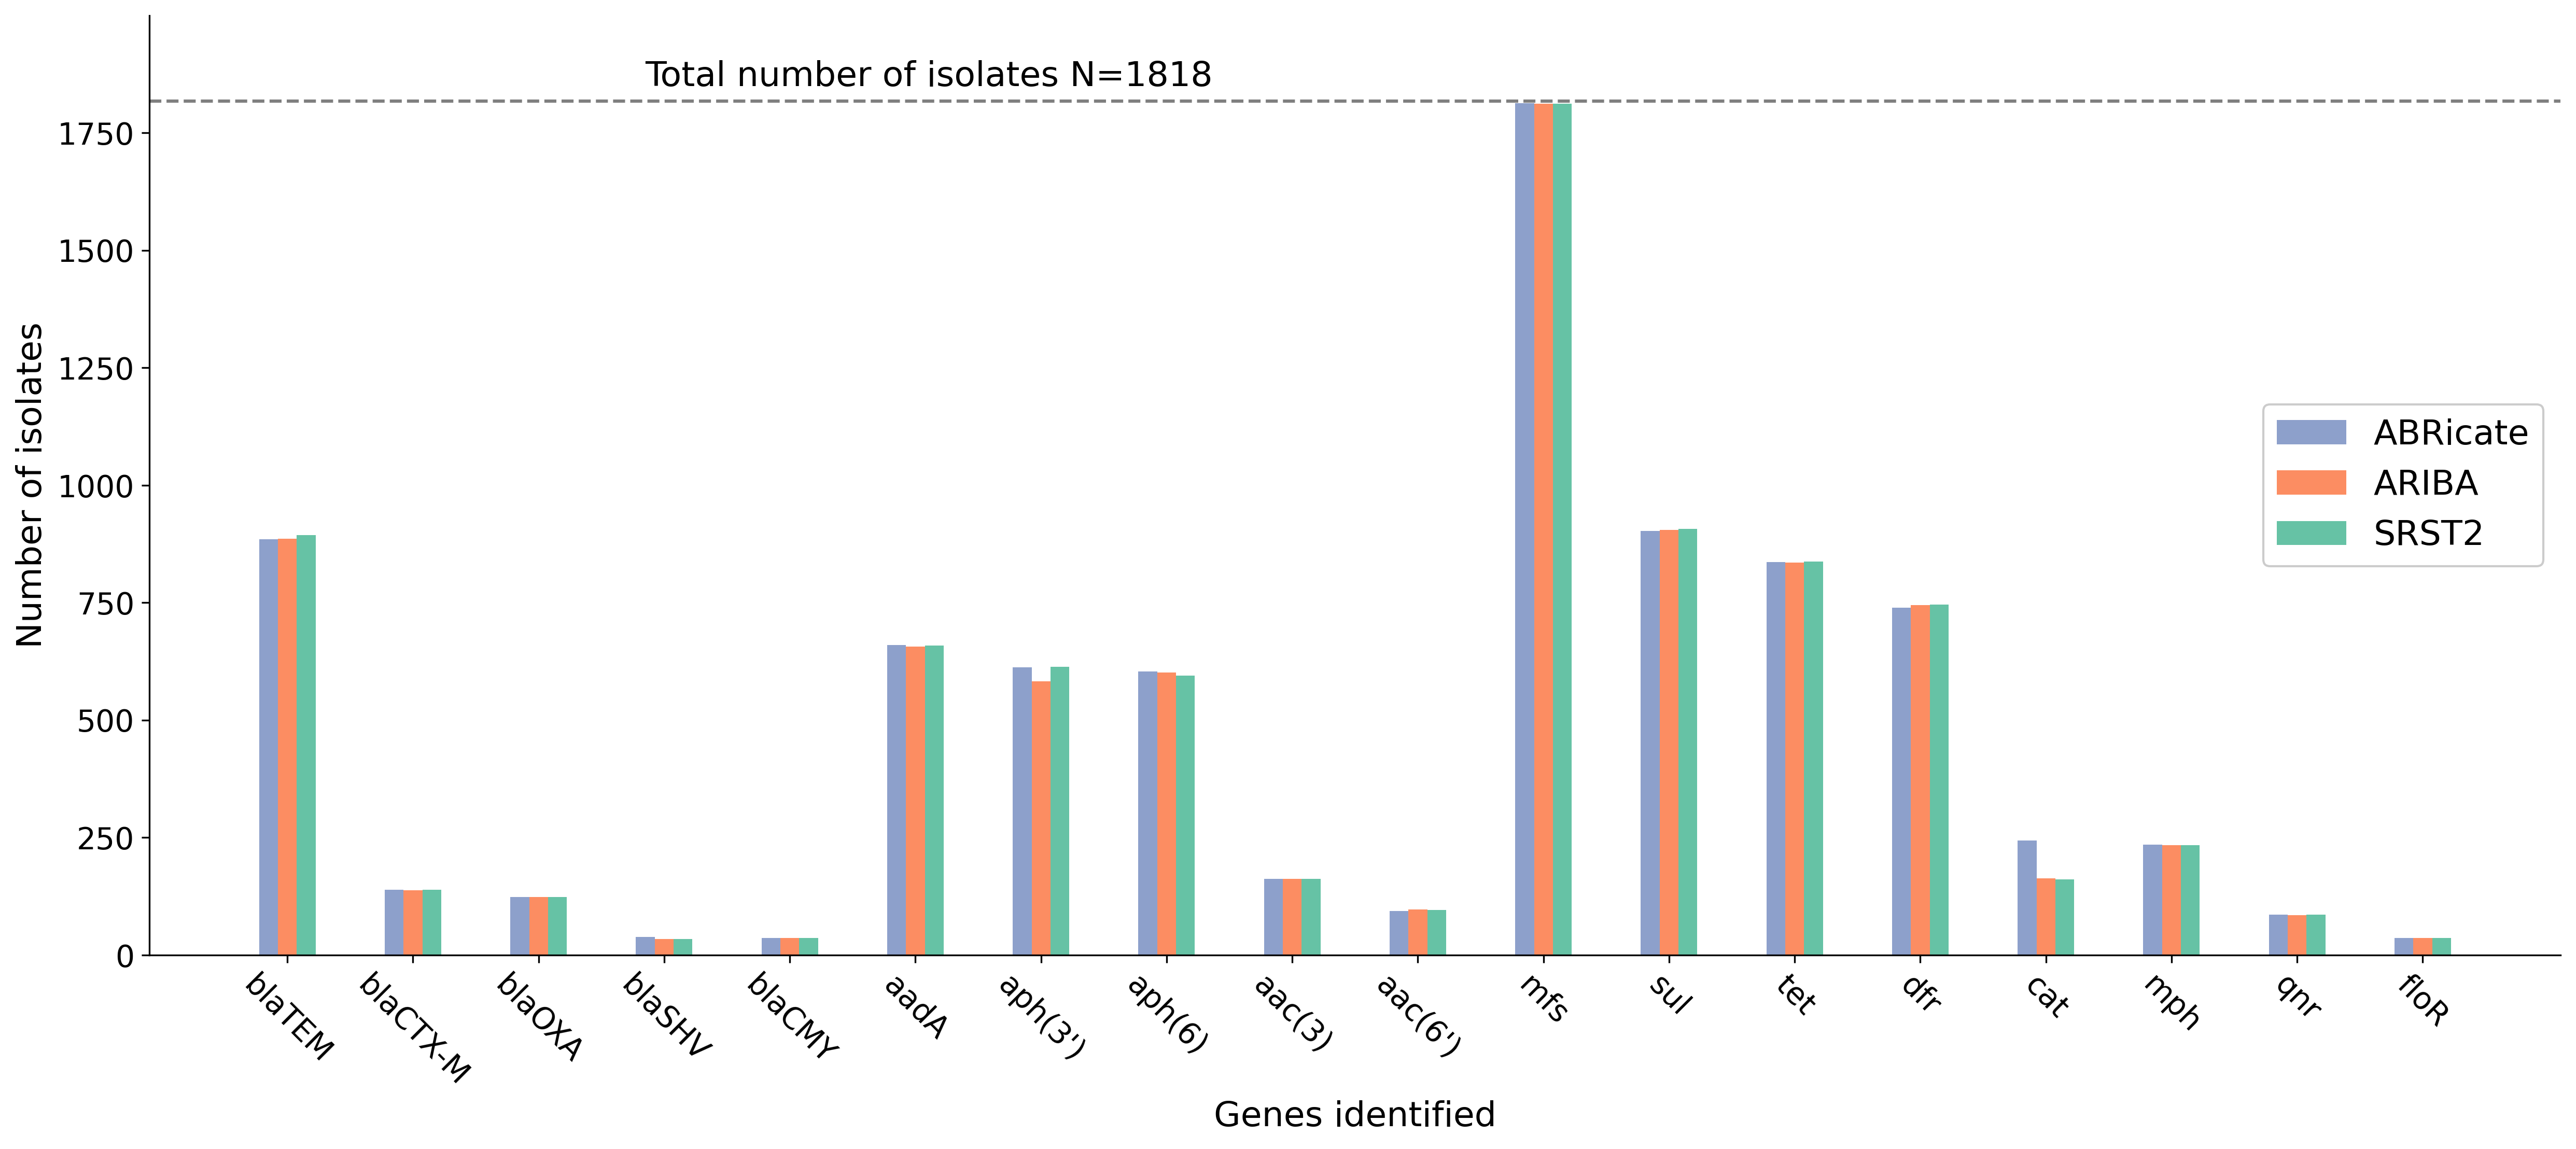

In [24]:
# =============================================================================
# Code block 7 - Producing figure 1 panel A
# =============================================================================

pic_nos = pic_nos_final["resfinder_20191001_full"]

fig = plt.figure(figsize=(20,8), dpi=300)
ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)

pic_nos_30 = []

for k in pic_nos:
    if pic_nos[k]["all"] > 30:
        pic_nos_30.append(k)


blms = sorted(["blaTEM", "blaCTX-M", "blaOXA", "blaSHV", "blaCMY"], key = lambda a : pic_nos[a]['all'], reverse=True)
ami = sorted(["aadA", "aph(3')", 'aph(6)','aac(3)', "aac(6')"], key = lambda a : pic_nos[a]['all'], reverse=True)
others = sorted([k for k in pic_nos_30 if k not in blms + ami], key = lambda a : pic_nos[a]['all'], reverse=True)

keys = blms + ami + others

x_0s = {}
x_1s = {}
x_2s = {}
x_3s = {}

for k in range(len(keys)):
    x_0s[keys[k]] = k
    x_1s[keys[k]] = k+0.15
    x_2s[keys[k]] = k+0.30
    x_3s[keys[k]] = k+0.45

ax.bar([x_0s[k] for k in keys],[pic_nos[k]['abricate'] for k in keys] ,width = 0.15, label="ABRicate", 
      color = "#8da0cb")    
ax.bar([x_1s[k] for k in keys],[pic_nos[k]['ariba'] for k in keys] ,width = 0.15, label = "ARIBA", 
      color = "#fc8d62")  
ax.bar([x_2s[k] for k in keys],[pic_nos[k]['srst2'] for k in keys] ,width = 0.15, label="SRST2",
      color=  "#66c2a5")  

ax.set_ylim(0, 2000)
ax.set_xticks([k+0.15 for k in range(len(keys))])
ax.set_xticklabels(keys, rotation = -45, size=14)
ax.set_xlabel("Genes identified", size = 16)
ax.set_ylabel("Number of isolates", size = 16)
ax.set_yticks([0, 250, 500, 750, 1000, 1250, 1500, 1750])
ax.set_yticklabels([0, 250, 500, 750, 1000, 1250, 1500, 1750], size=14)
ax.axhline(y=1818, color ="black", alpha=0.5, ls="--" )
ax.text( 3,  1850, "Total number of isolates N=1818", size=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="right", prop={'size': 16}, facecolor="white", framealpha=1)

plt.show()

        


resfinder_20191001_full {'Erm 23S ribosomal RNA methyltransferaseÊ': {'all': 3, 'abricate': 3, 'ariba': 3, 'kmerres': 0, 'srst2': 3}, 'mfs': {'all': 980, 'abricate': 980, 'ariba': 980, 'kmerres': 0, 'srst2': 980}, 'aac(3)': {'all': 55, 'abricate': 55, 'ariba': 55, 'kmerres': 0, 'srst2': 55}, 'mph': {'all': 129, 'abricate': 127, 'ariba': 126, 'kmerres': 0, 'srst2': 126}, 'aph(4)': {'all': 1, 'abricate': 1, 'ariba': 1, 'kmerres': 0, 'srst2': 1}, 'aadA': {'all': 252, 'abricate': 251, 'ariba': 251, 'kmerres': 0, 'srst2': 251}, 'blaCMY': {'all': 7, 'abricate': 7, 'ariba': 7, 'kmerres': 0, 'srst2': 7}, 'floR': {'all': 7, 'abricate': 7, 'ariba': 7, 'kmerres': 0, 'srst2': 7}, "aph(3')": {'all': 290, 'abricate': 289, 'ariba': 279, 'kmerres': 0, 'srst2': 290}, 'blaOXA': {'all': 63, 'abricate': 62, 'ariba': 62, 'kmerres': 0, 'srst2': 61}, 'tet': {'all': 315, 'abricate': 314, 'ariba': 313, 'kmerres': 0, 'srst2': 315}, 'dfr': {'all': 311, 'abricate': 306, 'ariba': 308, 'kmerres': 0, 'srst2': 308},

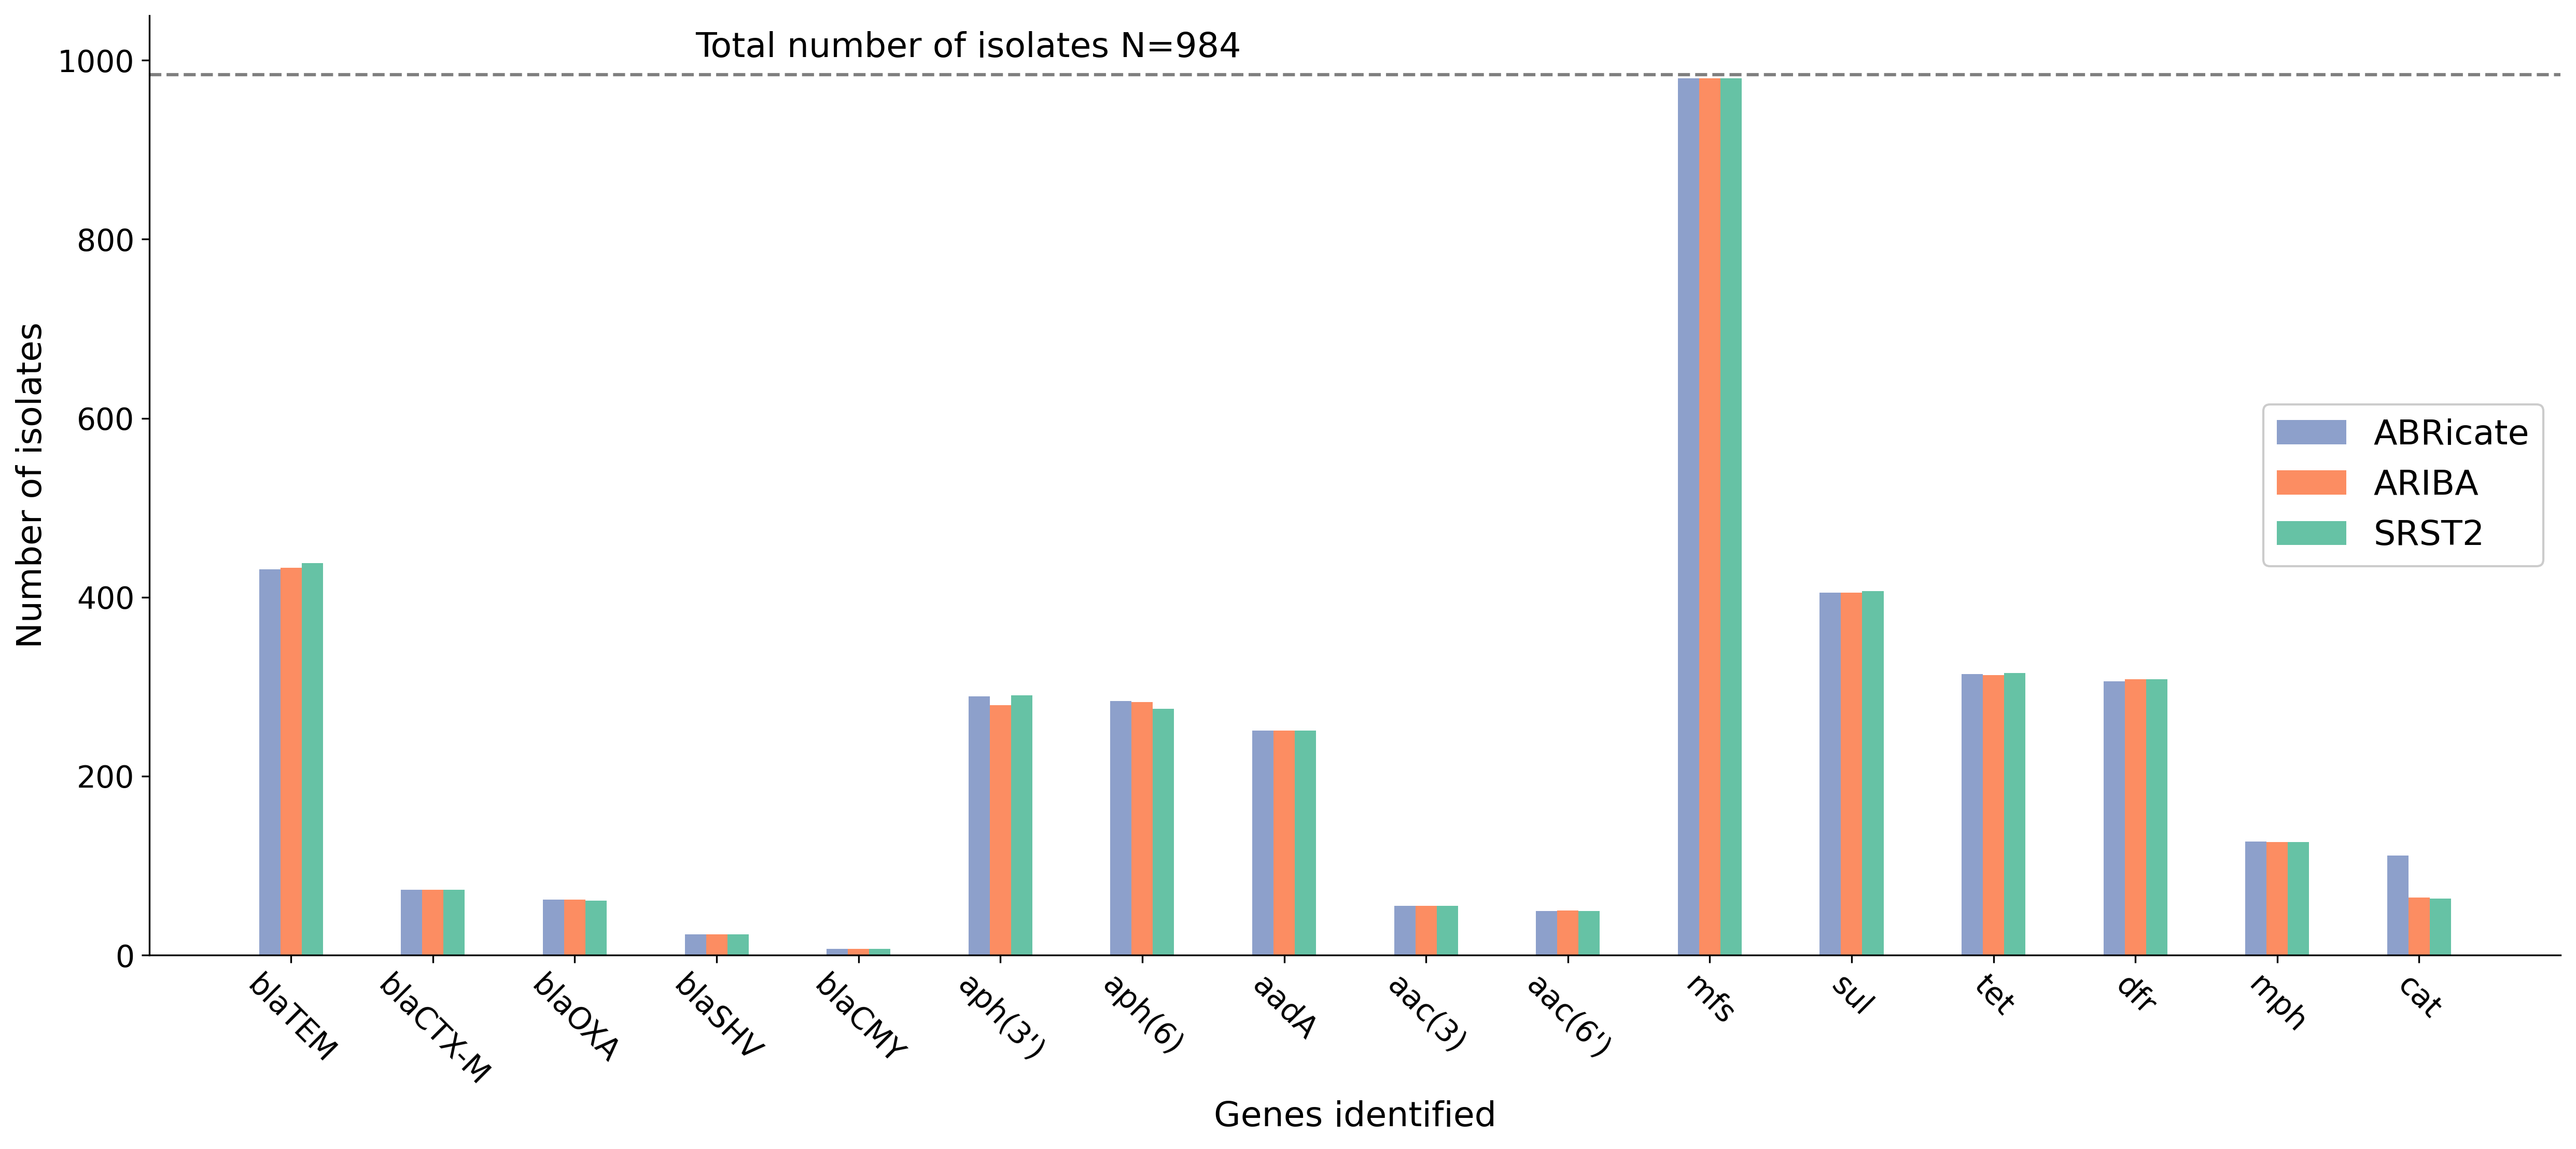

In [78]:
# =============================================================================
# Code block 8 - Producing similar supplementary figures for each of the sub datasets
# =============================================================================

# These are not included in the supplement, but an aggregate is
# For the aggregate I 

# Now this combines the two code blocks above but adds an option to just select a subset
# This code is a hakky version to get the previous code running on a subset

chosen_source = "OXFORD"
if chosen_source == "APHA":
    y_max = 550
    y_ticks = [0, 100, 200, 300, 400, 500]
    y_tick_labels = deepcopy(y_ticks)
    y_hline = 497
if chosen_source == "HICF":
    y_max = 350
    y_ticks = [0, 50, 100, 150,200,  250, 300, 350]
    y_tick_labels = deepcopy(y_ticks)
    y_hline = 337
if chosen_source == "OXFORD":
    y_max = 1050
    y_ticks = [0,200, 400, 600, 800, 1000]
    y_tick_labels = deepcopy(y_ticks)
    y_hline = 984
    
    
d = "resfinder_20191001_full"

sub_pic_nos = {}
sub_pic_nos_final = {}
d_gene_list = []
sim_matrix = sim_matrices[d]
jac_sim_matrix = jac_sim_matrices[d]
rlink = rlinks[d]
link = links[d]
for k in isolates[d]:
    if k in source[chosen_source]:
        for g in isolates[d][k].all_genes:
            d_gene_list.append(g)
# Overall its approximately 200 different alleles, but comes back down to being a single class. 
d_gene_list = sorted(list(set(d_gene_list)))
gene_df = pd.DataFrame(np.zeros((len(d_gene_list),len(d_gene_list) )), 
                   columns =d_gene_list, index=d_gene_list)
for l in gene_df.index:
    for j in gene_df.columns:
        gene_df.loc[l][j] = sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
gene_families = recursive_cluster(gene_df, gene_df.index)


kmer_df = pd.DataFrame(np.zeros((len(d_gene_list),len(d_gene_list) )), 
                       columns =d_gene_list, index=d_gene_list)
for m in tnrange(len(kmer_df.index)):
    l = kmer_df.index[m]
    for j in kmer_df.columns:
        kmer_df.loc[l][j] = jac_sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
kmer_families = recursive_cluster(kmer_df, kmer_df.index)

# Next onto naming
# THis is done in a separate spreadsheet, gene_naming.csv which links together gene, family,which genes they share kmers with 
# and then what its actual family is (as listed in the CARD database front end) and finally what it ends up being called as in sub_picutres
# Note for genes seen less than X times, they're grouped into "Other"

# Both for Figure 1, and generally to know how to group genes, we need to know how often they occur.
gene_nos = {g:0 for g in d_gene_list}
genemet_nos = {g:{"abricate":0, 
                  "ariba":0, 
                  "srst2":0} for g in d_gene_list}

for g in d_gene_list:
    for i in isolates[d]:
        if i in source[chosen_source]:
            if g in isolates[d][i].all_genes:
                gene_nos[g] += 1
            if g in isolates[d][i].abricate_genes:
                genemet_nos[g]["abricate"] += 1
            if g in isolates[d][i].ariba_genes:
                genemet_nos[g]["ariba"] += 1
            if g in isolates[d][i].srst2_genes:
                genemet_nos[g]["srst2"] += 1



# This however is a bit crude and can't really be used for counting genes, its just a useful set of dictionaries to have for latter times
# when looking at how common any given allele is. 

# so for sub_pictures we need a measure of how commonly a sub_picture gene is present.

sub_pic_genes_df = pd.read_csv("gene_naming.csv")
sub_pic_names = list(set(list(sub_pic_genes_df.picture_family)))
sub_pic_nos[d] = {}
sub_pic_nos_final[d] = {}
for name in sub_pic_names:
    sub_pic_nos[d][name] = {"all":0, "abricate":0, "ariba":0, "kmerres":0, "srst2":0}
for k in isolates[d]:
    if k in source[chosen_source]:
        for name in sub_pic_names:
            name_sequences = list(sub_pic_genes_df.loc[sub_pic_genes_df.picture_family==name].sequence)
            seq_found = 0
            abricate_found = 0
            ariba_found =0
            srst2_found = 0
            for seq in name_sequences:
                if seq in isolates[d][k].all_genes:
                    seq_found =1
                if seq in isolates[d][k].abricate_genes:
                    abricate_found = 1
                if seq in isolates[d][k].ariba_genes:
                    ariba_found = 1
                if seq in isolates[d][k].srst2_genes:
                    srst2_found = 1
            if seq_found == 1:
                sub_pic_nos[d][name]["all"] += 1
            if abricate_found == 1:
                sub_pic_nos[d][name]["abricate"] += 1
            if ariba_found == 1:
                sub_pic_nos[d][name]["ariba"] += 1
            if srst2_found == 1:
                sub_pic_nos[d][name]["srst2"] += 1

for name in sub_pic_nos[d]:
    if sub_pic_nos[d][name]['all'] == 0:
        pass
    else:
        sub_pic_nos_final[d][name] = sub_pic_nos[d][name]
print(d, sub_pic_nos_final[d])

        
sub_pic_nos = sub_pic_nos_final["resfinder_20191001_full"]

fig = plt.figure(figsize=(20,8), dpi=300)
ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)

sub_pic_nos_30 = []

for k in sub_pic_nos:
    if sub_pic_nos[k]["all"] > 30:
        sub_pic_nos_30.append(k)

        
def l_output(l):
    l_out = []
    for k in l:
        if k not in sub_pic_nos.keys():
            pass
        else:
            l_out.append(k)
    return l_out
        
        
blms = sorted(l_output(["blaTEM", "blaCTX-M", "blaOXA", "blaSHV", "blaCMY"]), key = lambda a : sub_pic_nos[a]['all'], reverse=True)
ami = sorted(l_output(["aadA", "aph(3')", 'aph(6)','aac(3)', "aac(6')"]), key = lambda a : sub_pic_nos[a]['all'], reverse=True)
others = sorted(l_output([k for k in sub_pic_nos_30 if k not in blms + ami]), key = lambda a : sub_pic_nos[a]['all'], reverse=True)

keys = blms + ami + others

x_0s = {}
x_1s = {}
x_2s = {}
x_3s = {}

for k in range(len(keys)):
    x_0s[keys[k]] = k
    x_1s[keys[k]] = k+0.15
    x_2s[keys[k]] = k+0.30
    x_3s[keys[k]] = k+0.45

ax.bar([x_0s[k] for k in keys],[sub_pic_nos[k]['abricate'] for k in keys] ,width = 0.15, label="ABRicate", 
      color = "#8da0cb")    
ax.bar([x_1s[k] for k in keys],[sub_pic_nos[k]['ariba'] for k in keys] ,width = 0.15, label = "ARIBA", 
      color = "#fc8d62")  
ax.bar([x_2s[k] for k in keys],[sub_pic_nos[k]['srst2'] for k in keys] ,width = 0.15, label="SRST2",
      color=  "#66c2a5")  

# I still need to work out heights


    
ax.set_ylim(0, y_max)
ax.set_xticks([k+0.15 for k in range(len(keys))])
ax.set_xticklabels(keys, rotation = -45, size=14)
ax.set_xlabel("Genes identified", size = 16)
ax.set_ylabel("Number of isolates", size = 16)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels, size=14)
ax.axhline(y=y_hline, color ="black", alpha=0.5, ls="--" )
ax.text( 3,  y_hline + 0.02*y_hline, "Total number of isolates N={0}" .format(y_hline), size=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="right", prop={'size': 16}, facecolor="white", framealpha=1)

plt.show()


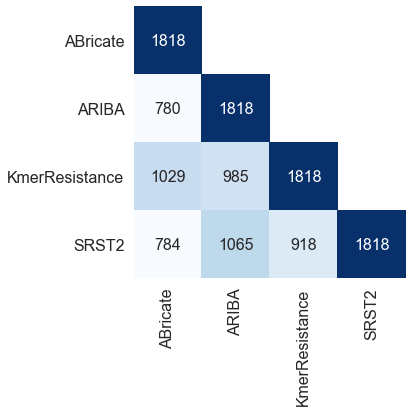

In [216]:
# =============================================================================
# Code block 8 - Producing individual figure 1 panel B
# =============================================================================

# THIS IS GOING TO BE AN UPSET PLOT

# fig = plt.figure(figsize=(8,8))
# ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)
sns.set()

all_agreement_df = pd.DataFrame(np.zeros((4,4), dtype=int), columns=["abricate", "ariba", "kmerres", "srst2"],
                           index=["abricate", "ariba", "kmerres", "srst2"])
all_agreement_np = np.zeros((4, 4))
db = "resfinder_20191001_full"


for m in range(len(all_agreement_df.index)):
    k = all_agreement_df.index[m]
    for n in range(len(all_agreement_df.index)):
        j = all_agreement_df.index[n]
        k_j_agreement = 0
        for i in isolates[db]:
            if sorted(isolates[db][i].geno_full[k]) == sorted(isolates[db][i].geno_full[j]):
                k_j_agreement += 1
        all_agreement_df.loc[k][j] = int(k_j_agreement)
        all_agreement_np[m][n] = int(k_j_agreement)

mask = np.array([[0,1,1,1],[0,0,1,1] , [0,0,0,1], [0,0,0,0]])


# I have spotted an error with the cmap here
# Probably easier will be to produce all 3 graphs in here
# Note I should also produce them with dpi=300

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(all_agreement_df, mask=mask,square=True, annot=True, fmt="d", annot_kws={"size": 16}, cmap="Blues", cbar=False, vmin=780, vmax=1818)
ax.set_yticklabels(["ABricate", "ARIBA", "KmerResistance", "SRST2"], rotation = 0, size=16)
ax.set_xticklabels(["ABricate", "ARIBA", "KmerResistance", "SRST2"], rotation = 90, size=16)
plt.show()


In [226]:
### Next we want to look at commonest patterns of alleles seen and their distribution

discrepancies = []

main_result = isolates["resfinder_20191001_full"]
for k in main_result:
    for j in main_result[k].gene_patterns:
        if main_result[k].gene_patterns[j] != [1,1,1,1]:
            discrepancies.append(j +"|"+":".join([str(m) for m in main_result[k].gene_patterns[j]]))

discrepancies = Counter(discrepancies)
gene_names = pd.read_csv("gene_naming.csv", index_col=0)
m = 0
for k in sorted(discrepancies, key = lambda a : discrepancies[a], reverse=True):
    k_origname = [gene_names.loc[i].picture_family for i in k.split("|")[0].split(":")]
    assert len(set(k_origname)) == 1
    k_final = k + "|" + k_origname[0]
    print(k_final, discrepancies[k])
    m += 1
print(m)   

tet(A)_4_AJ517790:tet(A)_6_AF534183|1:2:1:2|tet 391
sul1_2_U12338:sul1_5_EU780013|1:2:2:2|sul 304
mph(A)_1_D16251:mph(A)_2_U36578|1:2:2:2|mph 176
cmlA1_1_M64556:cml_1_M22614|1:1:1:2|mfs 137
aph(6)-Id_1_M28829:aph(6)-Id_4_CP000971|1:2:2:2|aph(6) 96
dfrA1_7_AJ400733:dfrA1_8_X00926|1:1:1:2|dfr 80
catB3_1_AJ009818:catB3_2_U13880|1:2:3:2|cat 73
dfrA30_1_AM997279:dfrA5_1_X12868|1:1:1:2|dfr 71
sul1_5_EU780013:sul1_2_U12338|1:2:2:2|sul 56
tet(A)_6_AF534183:tet(A)_4_AJ517790|1:2:1:2|tet 49
dfrA14_1_KF921535:dfrA14_5_DQ388123|1:2:2:2|dfr 49
qnrS1_1_AB187515:qnrS6_1_HQ631376|1:1:1:2|qnr 42
aph(6)-Id_1_M28829:aph(6)-Id_4_CP000971|1:2:1:1|aph(6) 41
mph(A)_2_U36578:mph(A)_1_D16251|1:2:2:2|mph 40
sul1_2_U12338:sul1_5_EU780013|1:2:1:2|sul 34
aph(3'')-Ib_5_AF321551|1:2:1:1|aph(3') 31
dfrA14_4_AF393510:dfrA14_5_DQ388123|1:2:2:2|dfr 31
aadA11_2_AJ567827:aadA12_1_AY665771:aadA17_1_FJ460181:aadA1_5_JX185132:aadA24_1_AM711129:ant(3'')-Ia_1_X02340|1:2:2:3|aadA 31
aph(3'')-Ib_2_AF024602:aph(3'')-Ib_3_AF321550

blaTEM-21_1_Y17582|1:2:1:1|blaTEM 1
blaCTX-M-139_1_KC107824:blaCTX-M-15_1_AY044436:blaCTX-M-183_1_KX263246|1:2:3:4|blaCTX-M 1
aph(3'')-Ib_3_AF321550:aph(3'')-Ib_4_AF313472:aph(3'')-Ib_2_AF024602|1:2:1:3|aph(3') 1
aadA15_1_DQ393783:aadA1_4_JQ480156:aadA24_1_AM711129:aadA24_1_DQ677333:aadA2b_1_D43625:aadA3_1_AF047479|1:2:1:3|aadA 1
dfrA12_8_AM040708|1:2:1:2|dfr 1
sul3_2_AJ459418|1:2:1:2|sul 1
dfrA14_4_AF393510|1:2:1:2|dfr 1
aadA15_1_DQ393783|1:2:1:1|aadA 1
blaTEM-57_1_FJ405211:blaTEM-1A_1_HM749966|1:1:2:1|blaTEM 1
aadA11_2_AJ567827:aadA12_1_AY665771:aadA21_1_AY171244:aadA2_1_NC_010870:aadA2b_1_D43625|1:2:1:3|aadA 1
dfrA7_1_AB161450|1:2:2:2|dfr 1
blaCMY-42_1_HM146927:blaCMY-90_1_HE819404|1:1:1:2|blaCMY 1
aadA11_2_AJ567827:aadA12_1_AY665771:aadA17_1_FJ460181:aadA1_2_FJ591054:aadA1_5_JX185132:ant(3'')-Ia_1_X02340|1:2:1:3|aadA 1
sul2_3_HQ840942:sul2_6_FN995456:sul2_10_AM183225:sul2_2_AY034138|1:2:3:4|sul 1
blaTEM-1A_1_HM749966:blaTEM-1C_1_FJ560503|1:2:1:1|blaTEM 1
aadA11_2_AJ567827:aadA13_1_

In [170]:
#### TRG PATTERN FILES

# Aggregating the patterns from all samples
pattern_counter = {}
pattern_bymethod = {}
pattern_byabx = {}
for i in isolates["resfinder_20191001_full"]:
    for k in isolates["resfinder_20191001_full"][i].genes_identified:
        pattern_key = k + "|" + isolates["resfinder_20191001_full"][i].genes_identified[k] 
        if pattern_key not in pattern_counter.keys():
            pattern_bymethod[pattern_key] = ":".join([str(j) for j in isolates["resfinder_20191001_full"][i].gene_patterns[k]])
            pattern_counter[pattern_key] = 1
            pattern_byabx[pattern_key] = isolates["resfinder_20191001_full"][i].gene_group[k]
        else:
            pattern_counter[pattern_key] += 1

print(pattern_byabx)
# writing this data into a CSV
with open("by_trg_pattern.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['trg_pattern',"abx", "number_of_isolates", "method_agreement", "overall_agreement"])
    for key in pattern_counter:
        writer.writerow([key,pattern_byabx[key], pattern_counter[key], pattern_bymethod[key], pattern_bymethod[key]=="1:1:1:1"])



AttributeError: 'isolate' object has no attribute 'gene_group'

In [ ]:
#### ISOLATE files:

with open("isolate_patterns.csv", "w") as f:
    writer = csv.writer(f, delimiter = ",")
    writer.writerow(["isolate", "pattern", "agreement"])
    for k in isolates:
        for pat in isolates[k].genes_identified:
            writer.writerow([k, pat, ("0" not in isolates[k].genes_identified[pat])])
        

In [ ]:
### For presentation stuff


annotated_patterns = pd.read_csv("pattern_annotator.csv")
gene_output = pd.read_csv("by_trg_pattern.csv")
pat_data = gene_output.merge(annotated_patterns, on="trg_pattern")
simulation_data = pd.read_csv("interpreting_simulations.csv")
print(simulation_data.head())

def met_agr(l):
    if l == "1:1:1:1":
        return "0"
    if l == "1:2:2:2":
        return "1"
    if l == "1:2:1:1":
        return "2"
    if l == "1:1:2:1":
        return "3"    
    if l == "1:1:1:2":
        return "4"
    else:
        return "5"

pat_dict = {}

pg_dict = {}
artefact_dict = {}

for k in range(len(pat_data)):
    k_data = pat_data.iloc[k]
    k_pat = k_data.trg_pattern.split("|")[0]
    sim_dat = (True in list(simulation_data.loc[simulation_data.pattern == k_pat].overall))
    if k_data.method_agreement == "1:1:1:1":
        k_status = "0"
    elif sim_dat == True:
        k_status = "1"
    else:
        k_status = "2"
    if k_data.gene_name not in pat_dict.keys():
        pat_dict[k_data.gene_name] = {str(i):0 for i in range(6)}
        artefact_dict[k_data.gene_name]  = {str(i):0 for i in range(3)}
    pat_dict[k_data.gene_name][met_agr(k_data.method_agreement)] += k_data.number_of_isolates
    artefact_dict[k_data.gene_name][k_status] += k_data.number_of_isolates
    pg_dict[k_data.gene_name] = k_data.abx_x


def ad_sum(d):
    try:
        return d["1"]/(d["1"]+d["2"])
    except ZeroDivisionError:
        return -1

for k in pg_dict:
    pg_dict[k] = (pg_dict[k], sum(pat_dict[k].values()),round(ad_sum(artefact_dict[k]), 2))

print(pat_dict)
for k in sorted(pg_dict.keys(), key = lambda a: (pg_dict[a][0],pg_dict[a][1]) , reverse = True):
    print(k, pg_dict[k])

In [ ]:
f  = plt.figure(figsize=(10, 5), dpi=300)
ax1 = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan=1)

f_keys = ["blaTEM", "blaCTX-M-1", "blaOXA-1","blaCMY", "blaSHV","blaCTX-M-9" , 
         "aph(6)-Id","aph(3'')-Ib", "ant(3'')-Ia", "aadA5", "aac(3)-IIa", "aac(6')-Ib", "aph(3')-Ia", 
         "aac(3)-IV", "aph(4)-Ia", 
         "qnrS",
         "dfrA7","dfrA1", "drfA12", "dfrA14" , "dfrA5", 
         "sul2","sul1", "sul3" ]
xs = range(len(f_keys))
f_0vals = [pat_dict[k]['0'] for k in f_keys]
f_1vals = [pat_dict[k]['1'] for k in f_keys]
f_2vals = [pat_dict[k]['2'] for k in f_keys]
f_3vals = [pat_dict[k]['3'] for k in f_keys]
f_4vals = [pat_dict[k]['4'] for k in f_keys]
f_5vals = [pat_dict[k]['5'] for k in f_keys]
def convert_numbers(l):
    out_list = []
    for k in l:
        if k != -1:
            out_list.append(str(int(100*k)) + "%")
        else:
            out_list.append("N/A")
    return out_list

print(f_0vals)
print(f_1vals)

f_numbers = convert_numbers([pg_dict[k][2] for k in f_keys])
print(f_numbers)
width = 0.5

ax1.bar(xs, f_0vals, width)
ax1.bar(xs, f_1vals, width,
             bottom=f_0vals, label="ABRicate discrepant")
ax1.bar(xs, f_2vals, width,
             bottom= [f_0vals[i]+ f_1vals[i] for i in range(len(f_0vals))], label="ARIBA discrepant")
ax1.bar(xs, f_3vals, width,
             bottom= [f_0vals[i]+ f_1vals[i]+f_2vals[i] for i in range(len(f_0vals))], label="KmerResistance discrepant")
ax1.bar(xs, f_4vals, width,
             bottom= [f_0vals[i]+ f_1vals[i]+f_2vals[i]+f_3vals[i] for i in range(len(f_0vals))], label="SRST2 discrepant")
ax1.bar(xs, f_5vals, width,
             bottom= [f_0vals[i]+ f_1vals[i]+f_2vals[i]+f_3vals[i]+f_4vals[i] for i in range(len(f_0vals))], label="Multiple discrepant")

ax1.set_xticks(range(len(f_keys)))
ax1.set_xticklabels(f_keys, rotation=90)
ax1.set_yticklabels([], rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
